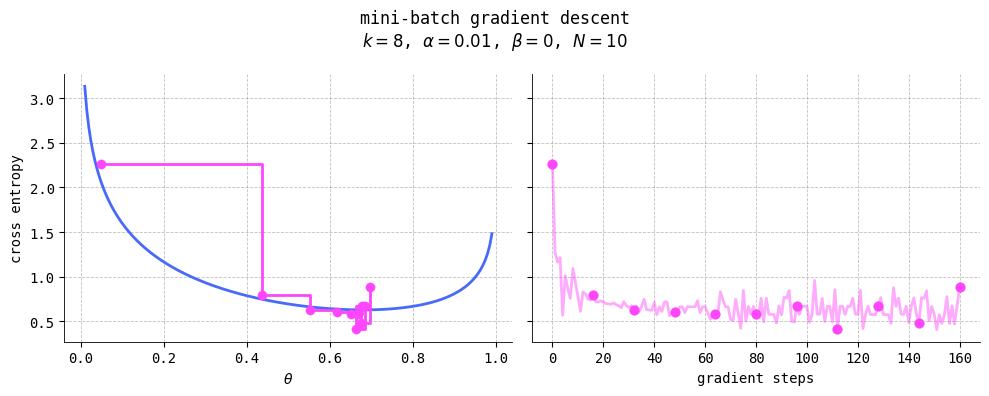

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.nn as nn
from math import sqrt
#import sys
#sys.path.append('/Users/johnmyers/code/stats-book-materials/notebooks')
from gd_utils import GD, SGD
#import matplotlib_inline.backend_inline
import matplotlib.colors as clr
plt.style.use('./aux-files/custom_style_light.mplstyle')
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
blue = '#486AFB'
magenta = '#FD46FC'

torch.manual_seed(42)
theta = 0.65
m = 128
X = torch.bernoulli(torch.tensor([theta] * m))

def g(X, parameters):
    theta = parameters['theta']
    return -X * torch.log(theta) - (1 - X) * torch.log(1 - theta)

def cross_entropy(theta):
    Sigmax = sum(X)
    return -(1 / m) * (Sigmax * np.log(theta) + (m - Sigmax) * np.log(1 - theta))

parameters = {'theta': torch.tensor([0.05])}
alpha = 0.01
k = 8
N = 10

sgd_output = SGD(g=g, init_parameters=parameters, X=X, lr=alpha, batch_size=k, num_epochs=N)

epoch_step_nums = sgd_output.epoch_step_nums
objectives = sgd_output.per_step_objectives[epoch_step_nums]
running_parameters = sgd_output.parameters['theta']
running_parameters = running_parameters[epoch_step_nums]
grid = np.linspace(start=0.01, stop=0.99, num=200)

_, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

axes[0].plot(grid, cross_entropy(grid))
axes[0].step(running_parameters, objectives, where='post', color=magenta)
axes[0].scatter(running_parameters, objectives, color=magenta, s=45, zorder=3)
axes[0].set_xlabel('$\\theta$')
axes[0].set_ylabel('cross entropy')

axes[1].plot(range(len(sgd_output.per_step_objectives)), sgd_output.per_step_objectives, color=magenta, alpha=0.45)
axes[1].scatter(epoch_step_nums, objectives, s=50, color=magenta, zorder=3)
axes[1].set_xlabel('gradient steps')

plt.suptitle(f'mini-batch gradient descent\n$k={k}$, $\\alpha = {alpha}$, $\\beta=0$, $N = {N}$')
plt.tight_layout()

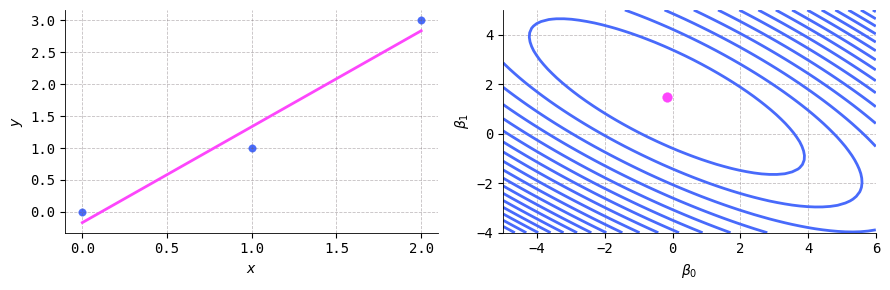

In [122]:
# toy data
X = np.array([[1, 0], [1, 1], [1, 2]])
y = np.array([0, 1, 3]).reshape(-1, 1)

# MLEs for parameters
beta0, beta1 = -1 / 6, 3 / 2

# define objective function
def J(theta, X, y):
    return -0.5 * np.linalg.norm(y - X @ theta, axis=0) ** 2

# define grid
x_grid = np.linspace(-5, 6)
y_grid = np.linspace(-4, 5)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
grid = np.column_stack((x_grid.reshape(-1, 1), y_grid.reshape(-1, 1))).T
z = J(grid, X, y).reshape(x_grid.shape)

# plot
_, axes = plt.subplots(ncols=2, figsize=(9, 3))

grid = np.linspace(0, 2)
axes[0].scatter(X[:, 1], y, s=30)
axes[0].plot(grid, beta0 + beta1 * grid, color=magenta)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')

axes[1].contour(x_grid, y_grid, z, levels=20, colors=blue, linestyles='solid')
axes[1].scatter([beta0], [beta1], s=50, color=magenta)
axes[1].set_xlabel('$\\beta_0$')
axes[1].set_ylabel('$\\beta_1$')

plt.tight_layout()

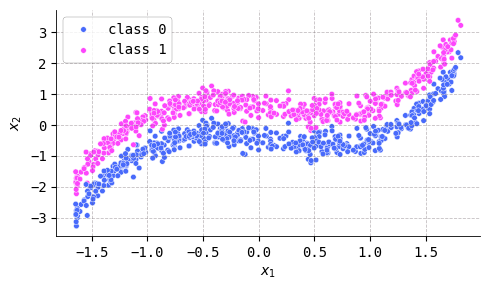

In [123]:
url = 'https://raw.githubusercontent.com/jmyers7/stats-book-materials/main/data/ch12-book-data-01.csv'
df = pd.read_csv(url)

# convert the data to numpy arrays
X = df[['x_1', 'x_2']].to_numpy()
y = df['y'].to_numpy()

# convert the data to torch tensors
X = torch.tensor(data=X, dtype=torch.float32)
y = torch.tensor(data=y, dtype=torch.float32)

# plot the data
g = sns.scatterplot(data=df, x='x_1', y='x_2', hue='y')

# change the default seaborn legend
g.legend_.set_title(None)
new_labels = ['class 0', 'class 1']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

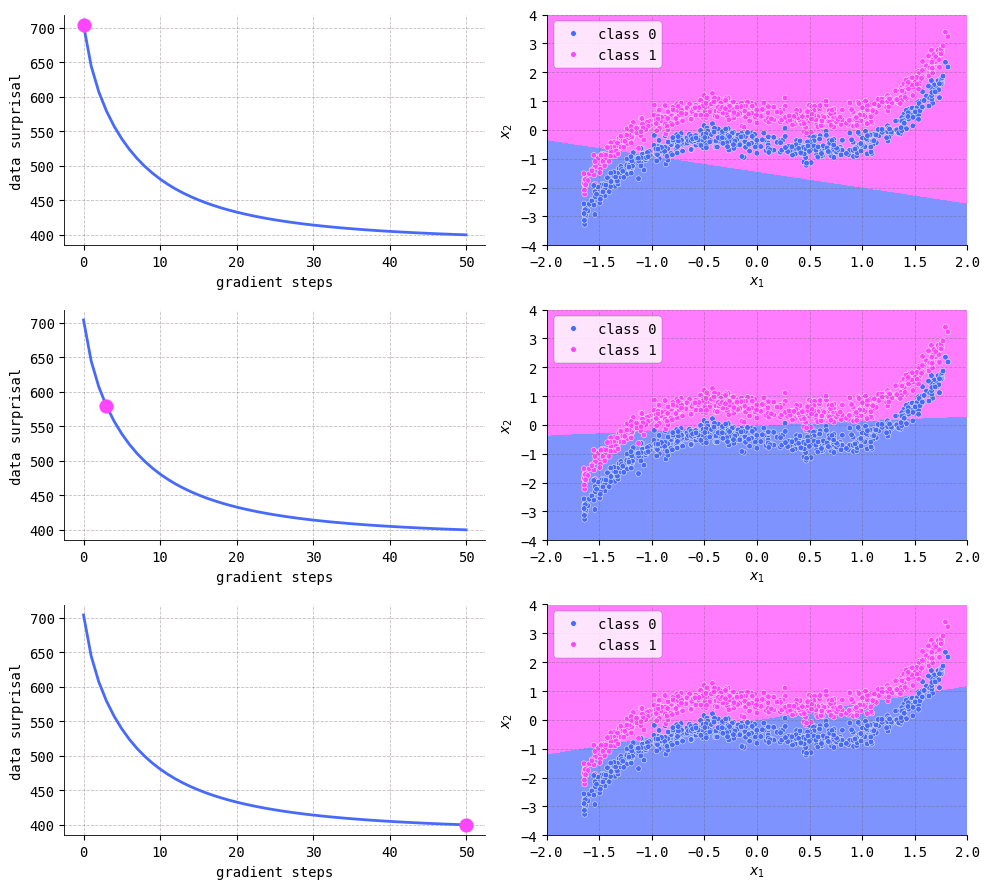

In [124]:
# define the link function at Y
def phi(X, parameters):
    beta0 = parameters['beta0']
    beta = parameters['beta']
    return torch.sigmoid(beta0 + X @ beta)

# define the data surprisal function
def I(parameters):
    probs = phi(X, parameters)
    return torch.sum(-y * torch.log(probs) - (1 - y) * torch.log(1 - probs))

# define the predictor
def predictor(X, parameters):
    probs = phi(X, parameters)
    return (probs >= 0.5).to(torch.int)

# initialize the weights and biases
torch.manual_seed(42)
beta0 = torch.normal(mean=0, std=1e-1, size=(1,))
beta = torch.normal(mean=0, std=1e-1, size=(2,))
theta0 = {'beta0': beta0, 'beta': beta}

# run gradient descent
N = 50
alpha = 1e-3
gd_output = GD(J=I, init_parameters=theta0, lr=alpha, num_steps=N)

# define grid for contour plot
resolution = 1000
x1_grid = torch.linspace(-2, 2, resolution)
x2_grid = torch.linspace(-4, 4, resolution)
x1_grid, x2_grid = torch.meshgrid(x1_grid, x2_grid)
grid = torch.column_stack((x1_grid.reshape((resolution ** 2, -1)), x2_grid.reshape((resolution ** 2, -1))))

# define colormap for the contour plots
desat_blue = '#7F93FF'
desat_magenta = '#FF7CFE'
binary_cmap = clr.LinearSegmentedColormap.from_list(name='binary', colors=[desat_blue, desat_magenta], N=2)

epoch_list = [0, 3, N]
running_parameters = gd_output.parameters

_, axes = plt.subplots(ncols=2, nrows=len(epoch_list), figsize=(10, 9))

for i, epoch in enumerate(epoch_list):
    parameters = {key: value[epoch] for key, value in running_parameters.items()}
    
    # plot the objective function
    axes[i, 0].plot(range(len(gd_output.objectives)), gd_output.objectives)
    axes[i, 0].set_xlabel('gradient steps')
    axes[i, 0].set_ylabel('data surprisal')
    axes[i, 0].scatter(epoch_list[i], gd_output.objectives[epoch], color=magenta, s=100, zorder=3)

    # apply the fitted model to the grid
    z = predictor(grid, parameters)

    # plot the decision boundary and colors
    z = z.reshape(shape=(resolution, resolution))
    axes[i, 1].contourf(x1_grid, x2_grid, z, cmap=binary_cmap)
    axes[i, 1].set_xlabel('$x_1$')
    axes[i, 1].set_ylabel('$x_2$')

    # plot the data
    g = sns.scatterplot(data=df, x='x_1', y='x_2', hue='y', ax=axes[i, 1])

    # change the default seaborn legend
    g.legend_.set_title(None)
    new_labels = ['class 0', 'class 1']
    for t, l in zip(g.legend_.texts, new_labels):
        t.set_text(l)
    
plt.tight_layout()

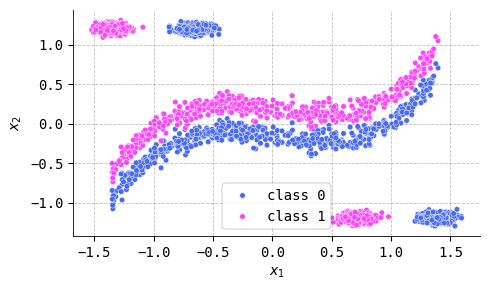

In [137]:
url = 'https://raw.githubusercontent.com/jmyers7/stats-book-materials/main/data/ch12-book-data-02.csv'
df = pd.read_csv(url)

# convert the data to numpy arrays
X = df[['x_1', 'x_2']].to_numpy()
y = df['y'].to_numpy()

# convert the data to torch tensors
X = torch.tensor(data=X, dtype=torch.float32)
y = torch.tensor(data=y, dtype=torch.float32)

# plot the data
g = sns.scatterplot(data=df, x='x_1', y='x_2', hue='y')

# change the default seaborn legend
g.legend_.set_title(None)
new_labels = ['class 0', 'class 1']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

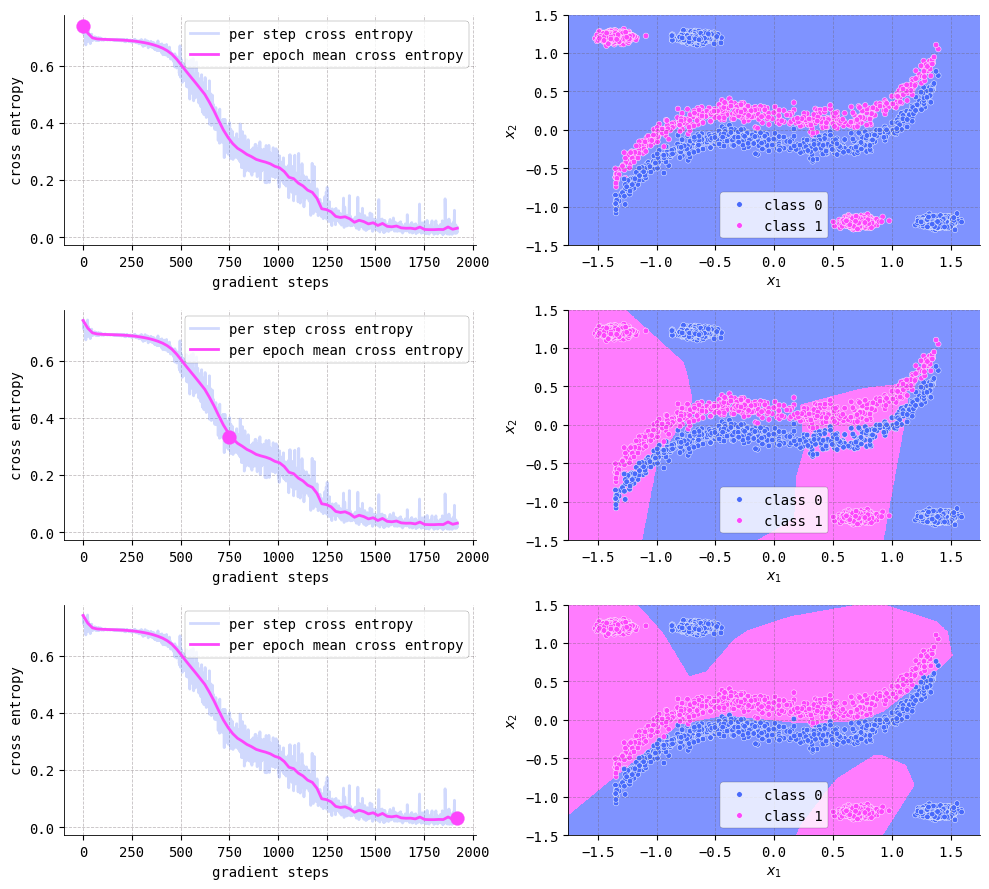

In [134]:
# define the link function at Y
def phi(X, parameters):
    Z_0 = X
    Z_1 = F.relu(Z_0 @ parameters['weight_1'] + parameters['bias_1'])
    Z_2 = F.relu(Z_1 @ parameters['weight_2'] + parameters['bias_2'])
    Z_3 = F.relu(Z_2 @ parameters['weight_3'] + parameters['bias_3'])
    return torch.sigmoid(Z_3 @ parameters['weight_4'] + parameters['bias_4'])

# define the model surprisal function
def I(X, y, parameters):
    probs = phi(X, parameters)
    return -y * torch.log(probs) - (1 - y) * torch.log(1 - probs)

# define the predictor
def predictor(X, parameters):
    probs = phi(X, parameters)
    return (probs >= 0.5).to(torch.int)

# define the network architecture
k1 = 8 # width of first hidden layer
k2 = 8 # width of second hidden layer
k3 = 4 # width of third hidden layer
widths = [2, k1, k2, k3, 1]

# initialize the weights and biases
torch.manual_seed(42)
theta0 = {}
for i in range(1, 5):
    weight = torch.empty(widths[i-1], widths[i])
    bias = torch.empty(widths[i])
    nn.init.uniform_(weight, a=-1/sqrt(widths[i-1]), b=1/sqrt(widths[i-1]))
    nn.init.uniform_(bias, a=-1/sqrt(widths[i-1]), b=1/sqrt(widths[i-1]))
    theta0 = theta0 | {'weight_' + str(i): weight.squeeze()}
    theta0 = theta0 | {'bias_' + str(i): bias}

# run SGD
N = 80
k = 128
alpha = 0.1
sgd_output = SGD(g=I, init_parameters=theta0, X=X, y=y, lr=alpha, batch_size=k, num_epochs=N, random_state=42)

# get the grid for the contour plot
resolution = 1000
x1_grid = torch.linspace(-1.75, 1.75, resolution)
x2_grid = torch.linspace(-1.5, 1.5, resolution)
x1_grid, x2_grid = torch.meshgrid(x1_grid, x2_grid)
grid = torch.column_stack((x1_grid.reshape((resolution ** 2, -1)), x2_grid.reshape((resolution ** 2, -1))))

epoch_list = [0, 750, len(sgd_output.per_step_objectives) - 1]
running_parameters = sgd_output.parameters

_, axes = plt.subplots(ncols=2, nrows=len(epoch_list), figsize=(10, 9))

for i, epoch in enumerate(epoch_list):
    parameters = {key: value[epoch] for key, value in running_parameters.items()}
    
    # plot the objective function
    axes[i, 0].plot(sgd_output.grad_steps, sgd_output.per_step_objectives, alpha=0.25, label='per step cross entropy')
    axes[i, 0].plot(sgd_output.epoch_step_nums, sgd_output.per_epoch_objectives, label='per epoch mean cross entropy')
    axes[i, 0].set_xlabel('gradient steps')
    axes[i, 0].set_ylabel('cross entropy')
    axes[i, 0].scatter(epoch_list[i], sgd_output.per_step_objectives[epoch], color=magenta, s=100, zorder=3)
    axes[i, 0].legend()

    # apply the fitted model to the grid
    z = predictor(grid, parameters)

    # plot the decision boundary and colors
    z = z.reshape(shape=(resolution, resolution))
    axes[i, 1].contourf(x1_grid, x2_grid, z, cmap=binary_cmap)
    axes[i, 1].set_xlabel('$x_1$')
    axes[i, 1].set_ylabel('$x_2$')

    # plot the data
    g = sns.scatterplot(data=df, x='x_1', y='x_2', hue='y', ax=axes[i, 1])

    # change the default seaborn legend
    g.legend_.set_title(None)
    new_labels = ['class 0', 'class 1']
    for t, l in zip(g.legend_.texts, new_labels):
        t.set_text(l)
    
plt.tight_layout()